In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

In [3]:
import numpy as np
import pandas as pd


from scipy.stats import norm
from scipy.io import loadmat

from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.stats import norm
import multiprocessing as mp
from scipy.fft import fft, ifft, fftshift,ifftshift
from scipy.signal import fftconvolve

In [4]:
time_min=-3
time_max=3
nx = 500000

time =np.arange(time_min,time_max,(time_max-time_min)/(nx-1))

currents = np.linspace(100,500,5)

tIndex = np.intersect1d(np.where(time*1e3>0),np.where(time*1e3<10))

In [5]:
def getDiameters():
    
   
    minDiam = .1
    maxDiam = 15
    
    d = np.linspace(minDiam,maxDiam,2000)*1e-6

    return d

d = getDiameters()  

In [6]:
binSizeSamples = np.diff(d)[0]

In [7]:
binSizeSamples/8.51063829787236e-08

0.0875812906453224

<IPython.core.display.Javascript object>


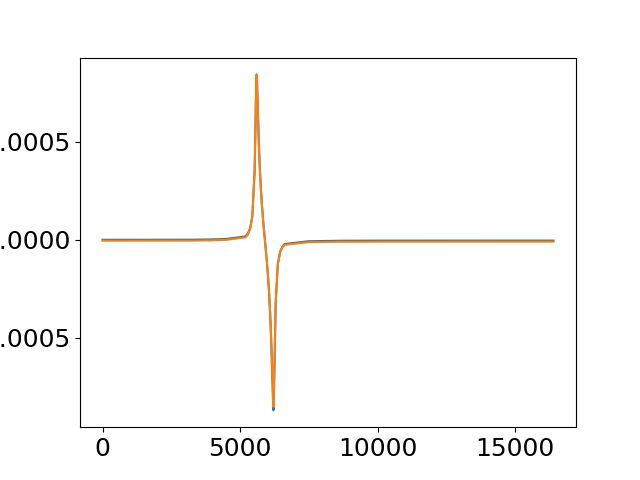

<IPython.core.display.Javascript object>


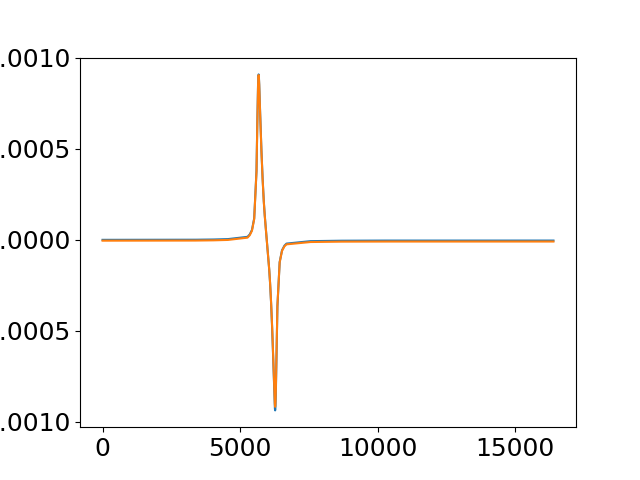

<IPython.core.display.Javascript object>


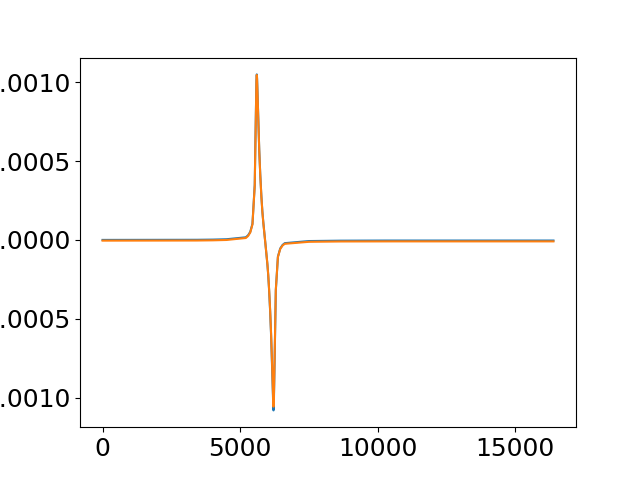

<IPython.core.display.Javascript object>


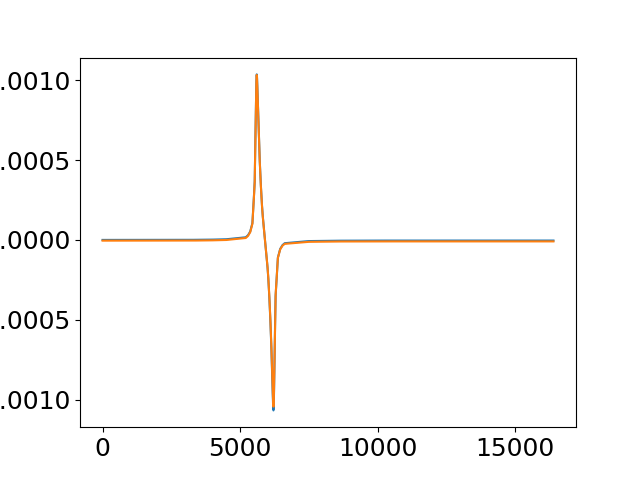

<IPython.core.display.Javascript object>


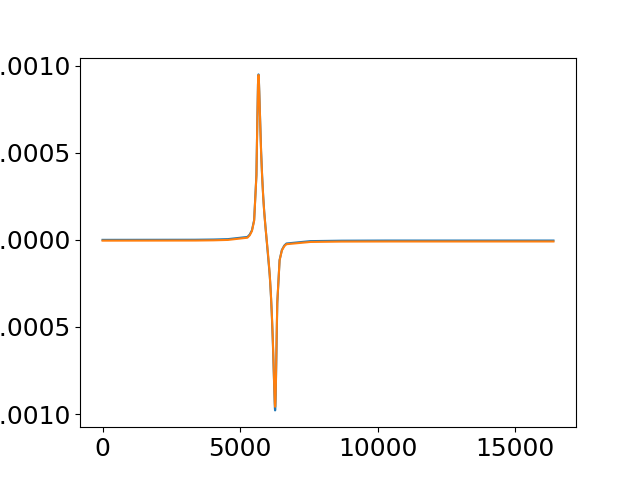

<IPython.core.display.Javascript object>


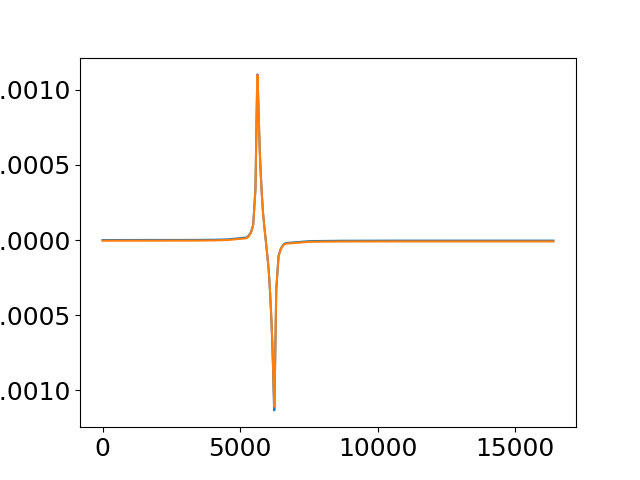

<IPython.core.display.Javascript object>


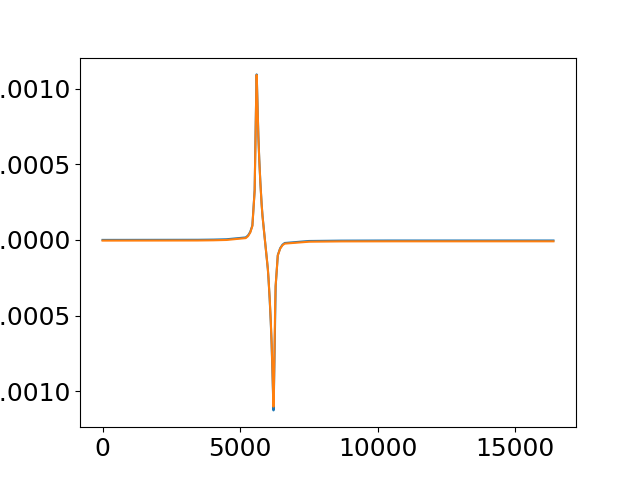

<IPython.core.display.Javascript object>


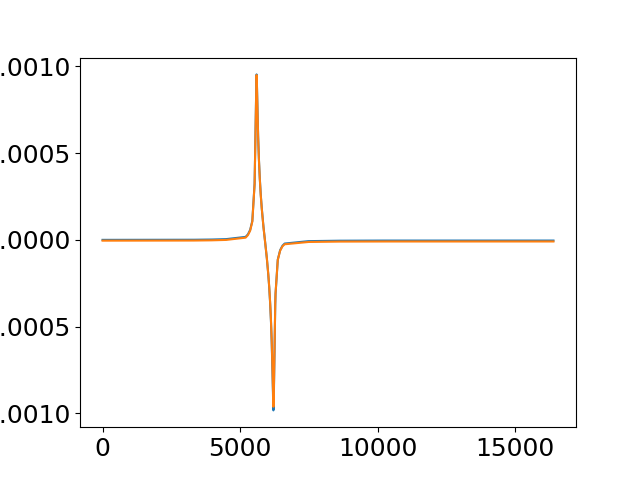

<IPython.core.display.Javascript object>


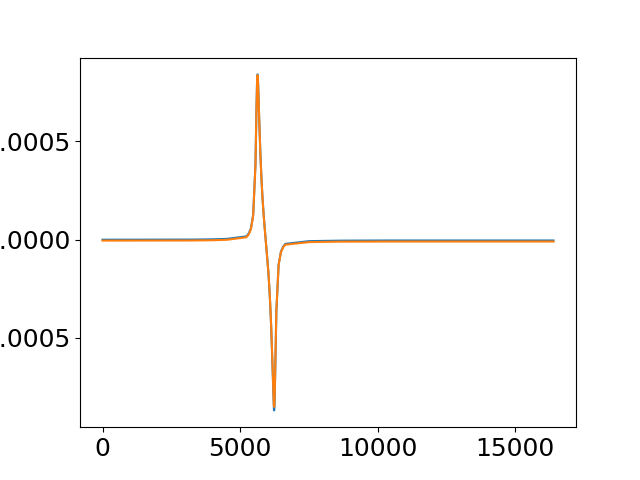

<IPython.core.display.Javascript object>


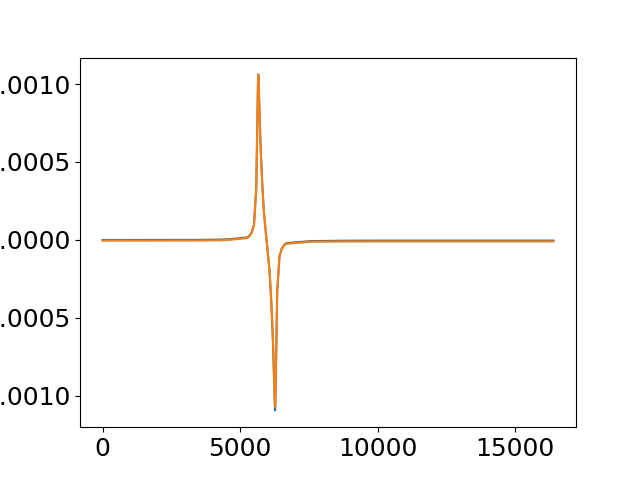

<IPython.core.display.Javascript object>


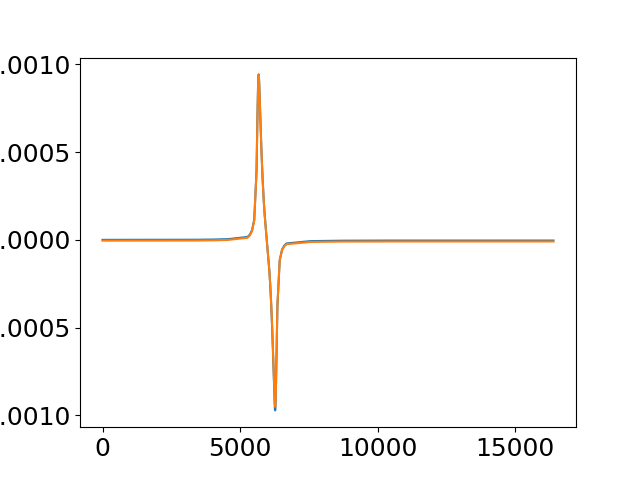

<IPython.core.display.Javascript object>


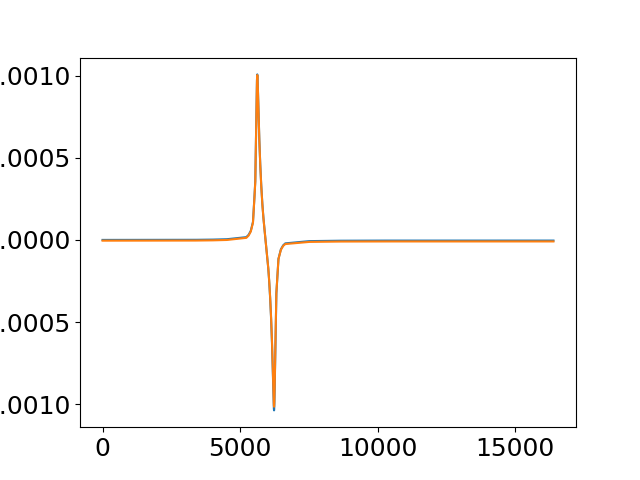

<IPython.core.display.Javascript object>


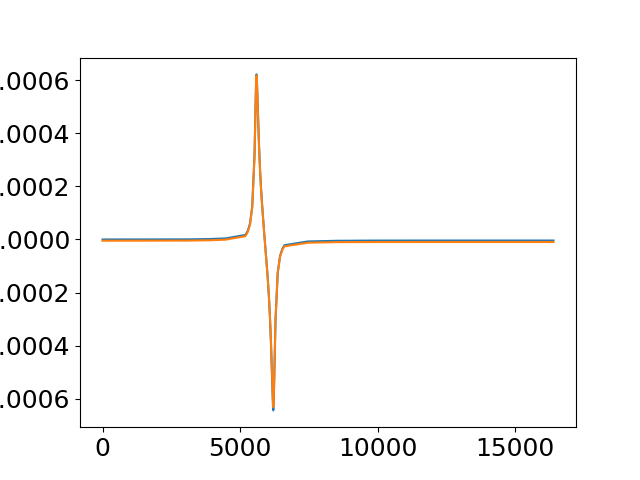

<IPython.core.display.Javascript object>


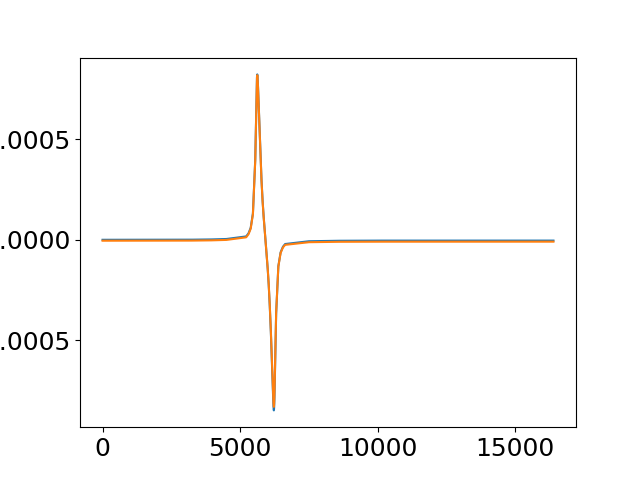

<IPython.core.display.Javascript object>


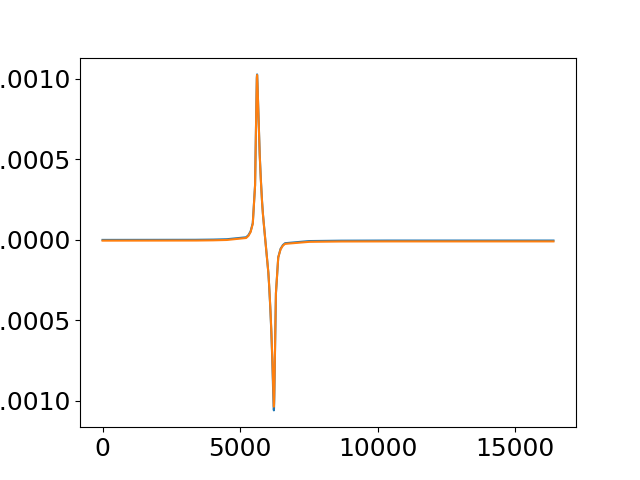

<IPython.core.display.Javascript object>


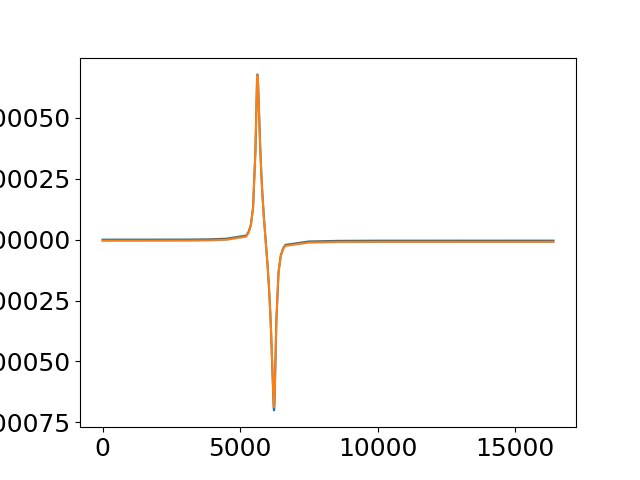

<IPython.core.display.Javascript object>


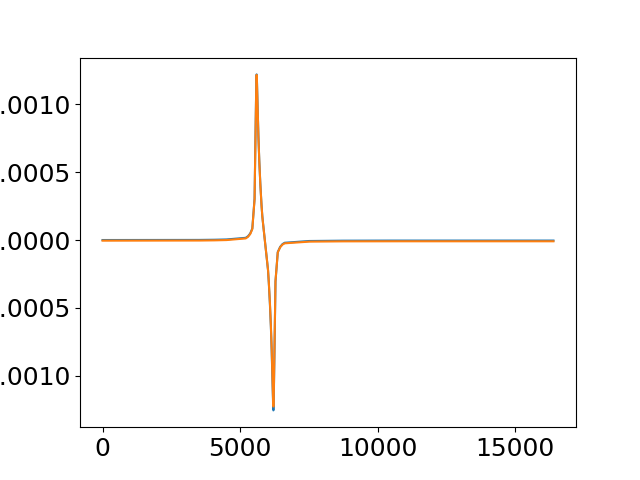

<IPython.core.display.Javascript object>


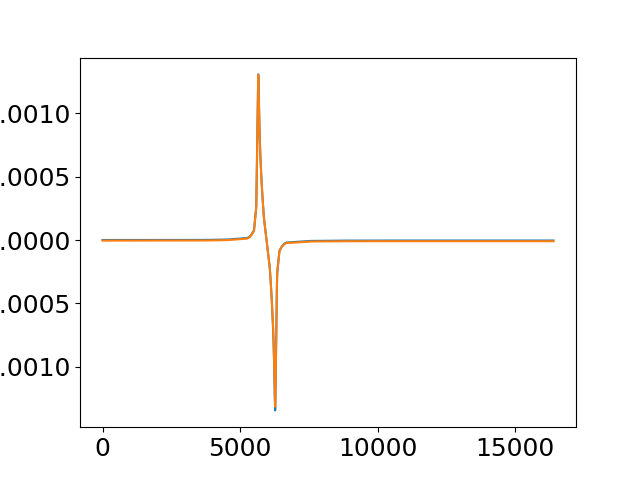

<IPython.core.display.Javascript object>


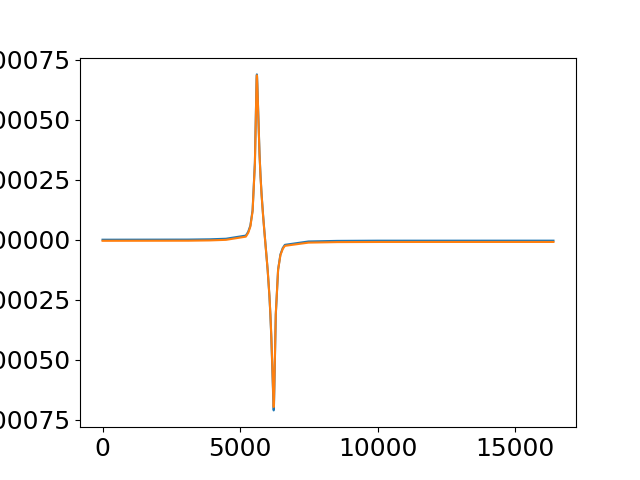

<IPython.core.display.Javascript object>


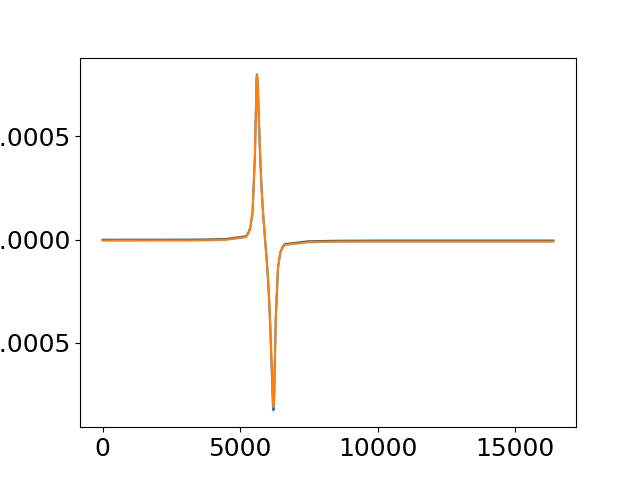

/gpfs/bbp.cscs.ch/home/tharayil/bluepy-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


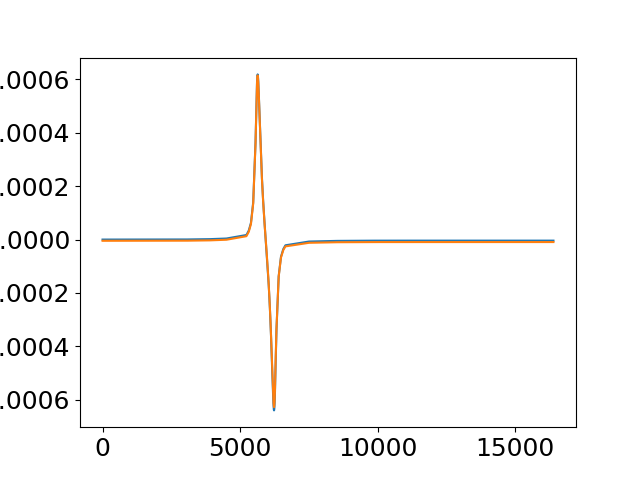

<IPython.core.display.Javascript object>


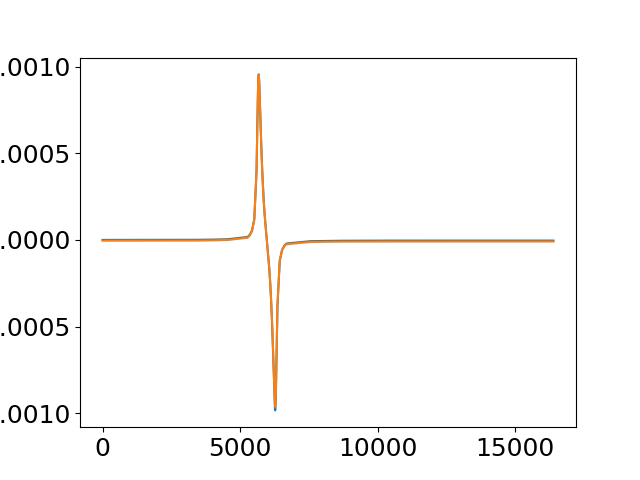

<IPython.core.display.Javascript object>


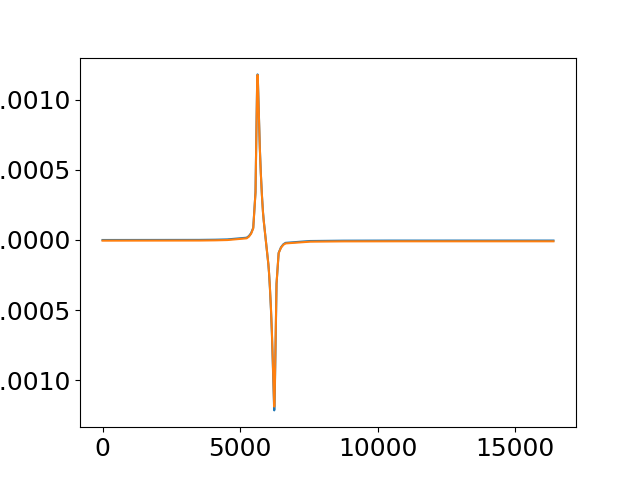

<IPython.core.display.Javascript object>


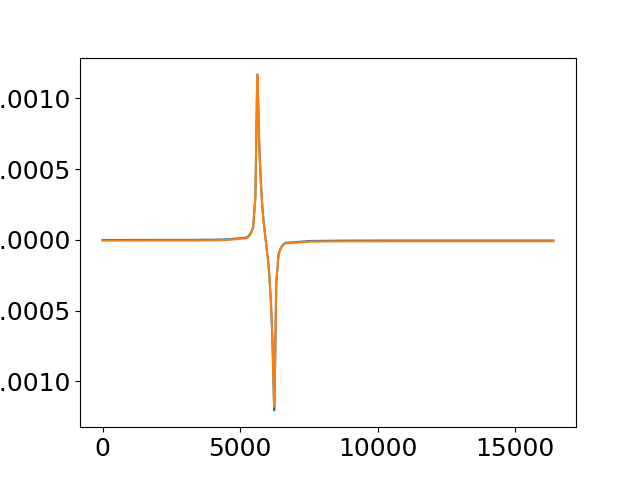

<IPython.core.display.Javascript object>


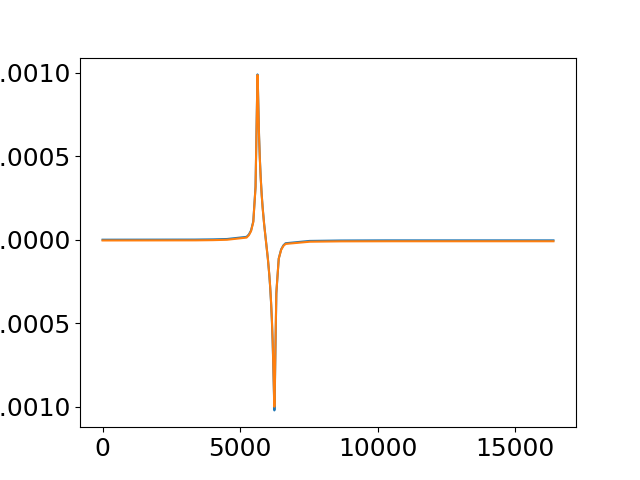

<IPython.core.display.Javascript object>


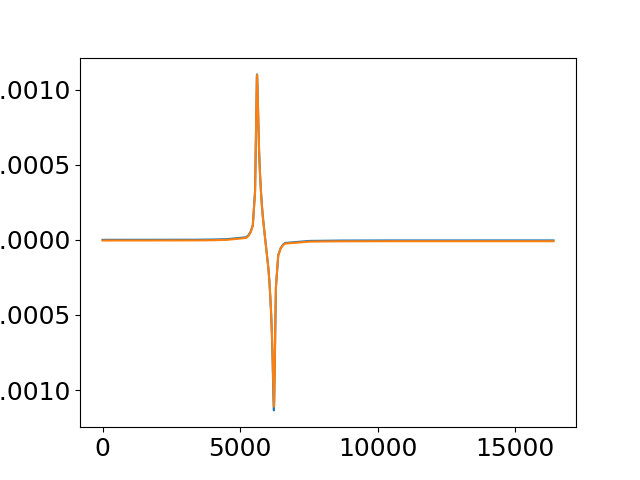

<IPython.core.display.Javascript object>


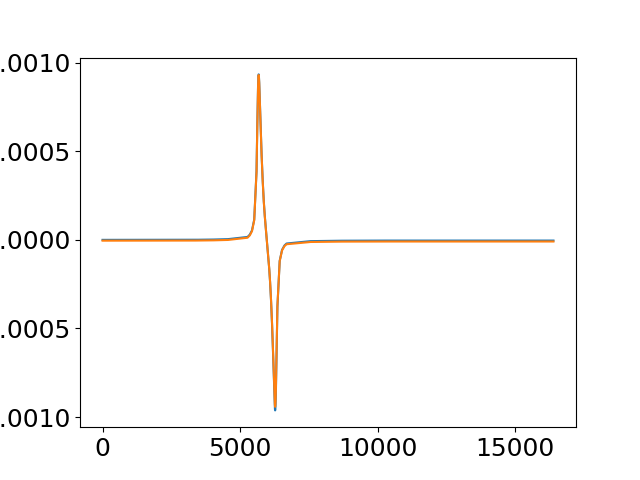

<IPython.core.display.Javascript object>


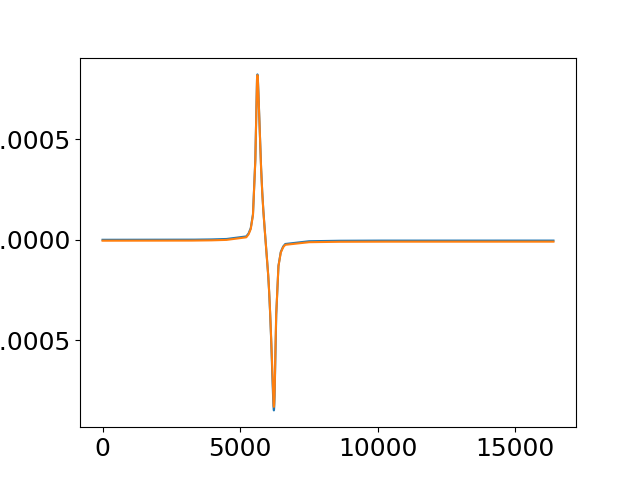

<IPython.core.display.Javascript object>


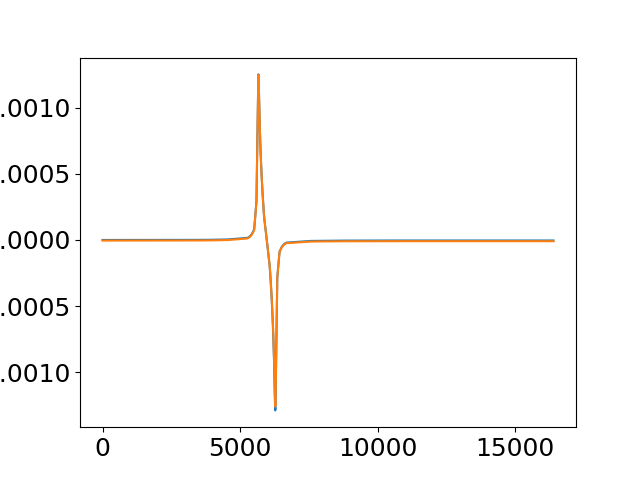

<IPython.core.display.Javascript object>


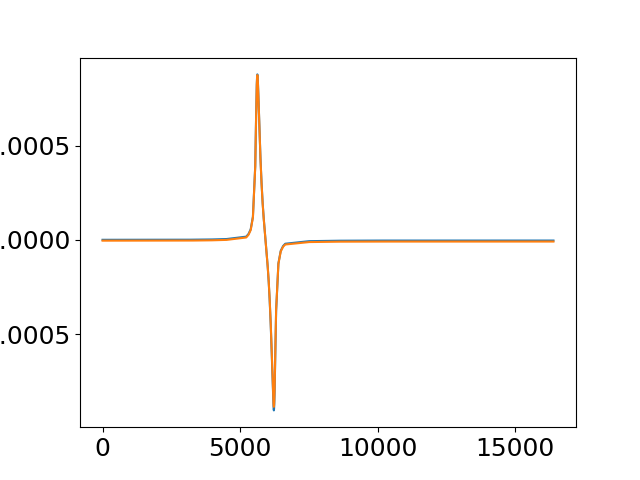

<IPython.core.display.Javascript object>


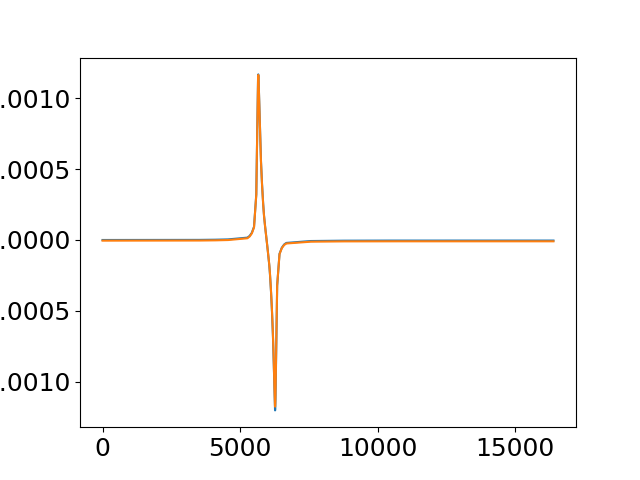

<IPython.core.display.Javascript object>


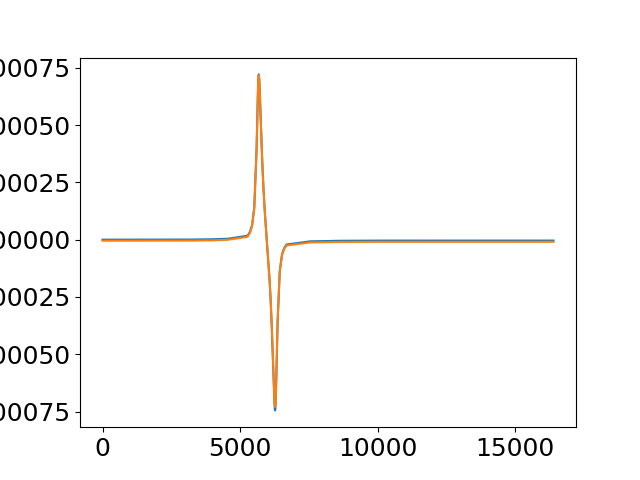

<IPython.core.display.Javascript object>


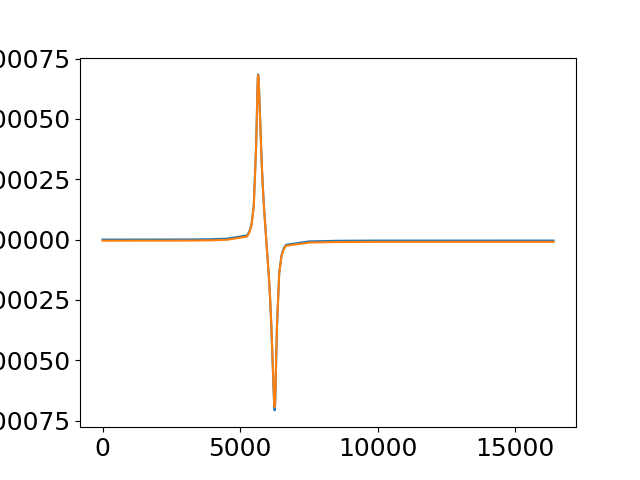

<IPython.core.display.Javascript object>


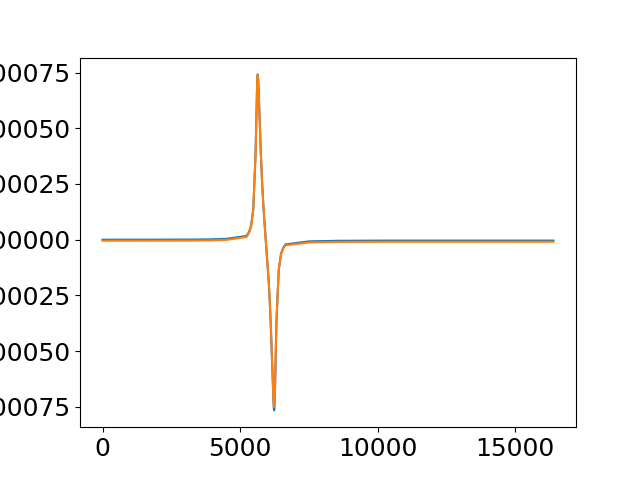

<IPython.core.display.Javascript object>


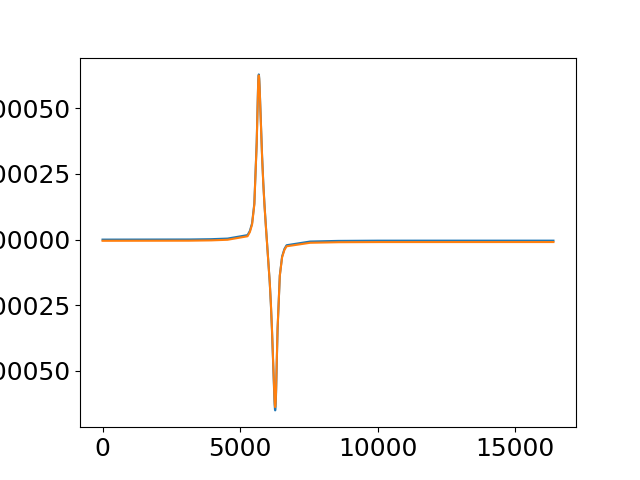

<IPython.core.display.Javascript object>


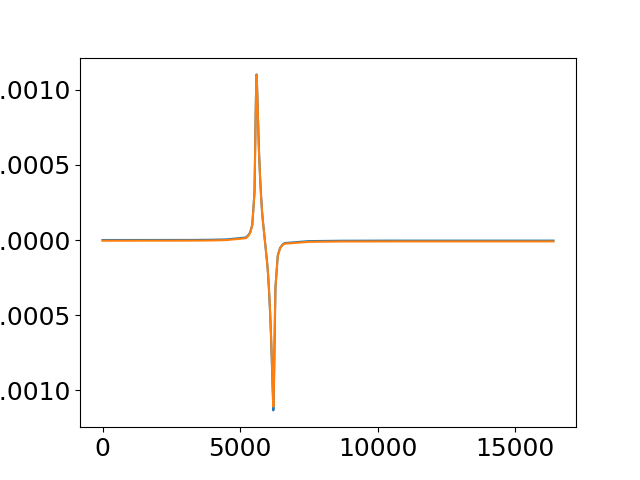

<IPython.core.display.Javascript object>


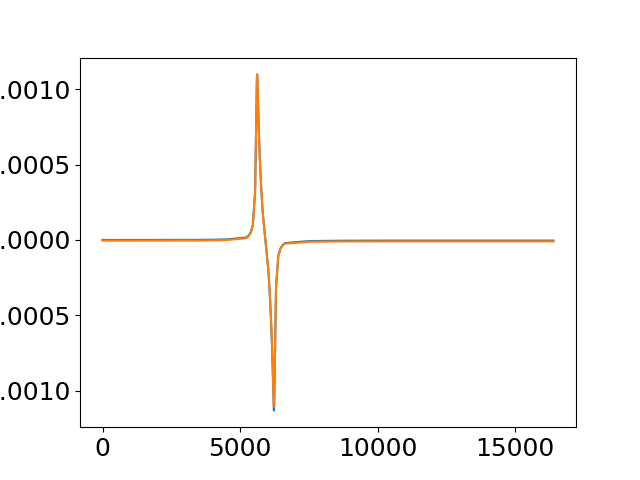

<IPython.core.display.Javascript object>


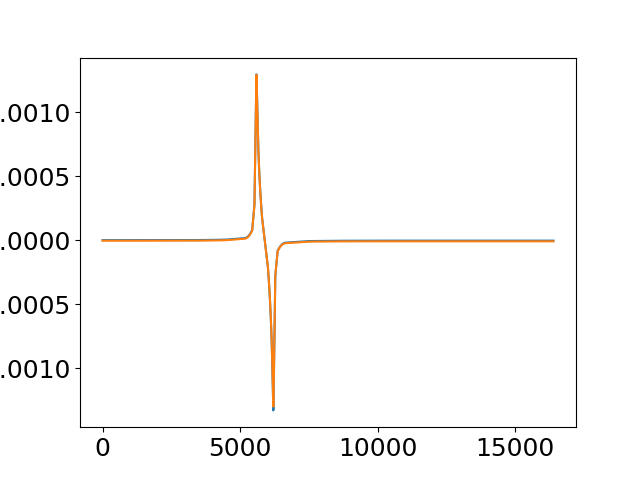

<IPython.core.display.Javascript object>


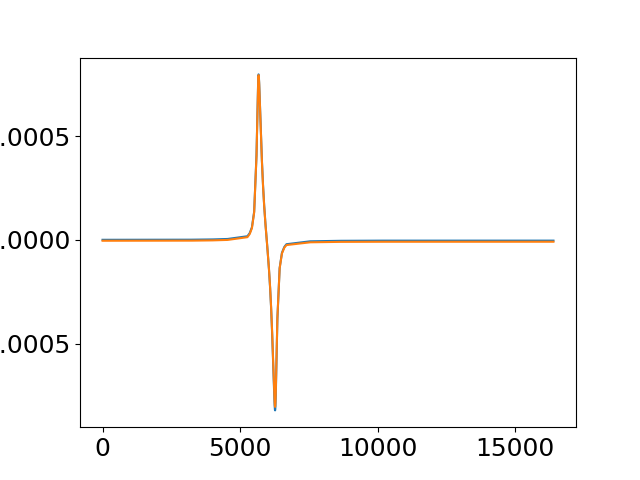

In [9]:
for fascIdx in range(39):

    plt.figure()

    phi = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Monopolar_Corrected/'+str(fascIdx)+'_BetterConductivity.xlsx')


    phiF = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Monopolar_Far_Corrected/'+str(fascIdx)+'_BetterConductivity.xlsx')

    phiB = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Bipolar_Corrected/'+str(fascIdx)+'_BetterConductivity.xlsx')


    plt.plot(phi.iloc[:,1]/460-phiF.iloc[:,1]/452)
    plt.plot(phiB.iloc[:,1]/509)

<IPython.core.display.Javascript object>


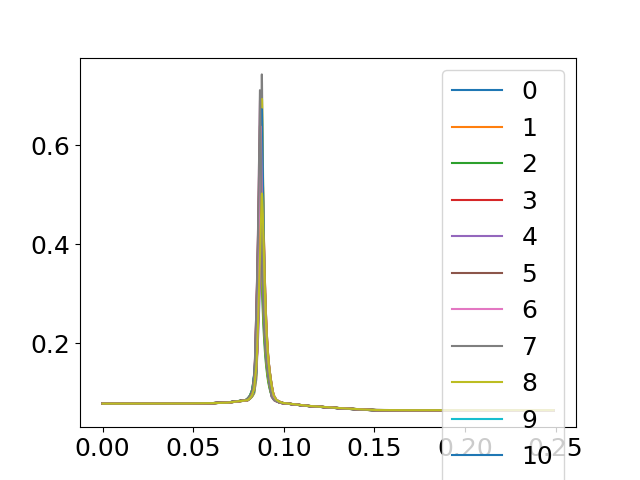

/gpfs/bbp.cscs.ch/home/tharayil/bluepy-env/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  # This is added back by InteractiveShellApp.init_path()


In [14]:
plt.figure()

for fascIdx in range(39):
    
    phi = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Monopolar/'+str(fascIdx)+'_BetterConductivity.xlsx')

    plt.plot(phi.iloc[:,0],phi.iloc[:,1])
    
plt.legend(np.arange(39))
    
plt.tight_layout()


In [23]:
def editPhiShape_Bipolar(phi,distance):
    
    ''' 
    This function takes the recording exposure curve from S4L, shifts it to match the desired distance from stimulus to recording, and smooths it
    '''
    
    xvals = phi.iloc[:,0].values+distance - 0.0798 - .00622 #-phi.iloc[np.argmax(phi.iloc[:,1].values),0] # Shift to match desired distance

    phiShapeEmpirical = phi.iloc[:,1].values-np.mean(phi.iloc[:,1])

    
   ######## 
    
    ####### Makes sure that the potential at the proximal end of the fiber goes all the way to zero

    if np.any(phiShapeEmpirical[:np.argmax(phiShapeEmpirical)]<0): # If the potential is negative at the end of the fiber, sets the potential to 0
        
        
        first = np.where(phiShapeEmpirical[:np.argmax(phiShapeEmpirical)]<0)[0][-1]    
        
        phiShapeEmpirical[:first] = 0
        
    else: # If the potential does not go all the way to 0 by the end of the fiber, forces it to zero
        
        first = np.where(np.abs(np.diff(phiShapeEmpirical))>1e-4)[0][0] # Based on derivative of function, selects point after whcih not to change values
        

        ### Linearizes potential before this point, up until it reaches 0 
        firsta = np.where(phiShapeEmpirical[first]-1e-4*np.arange(first)<0)[0][0]
        firsta = first-firsta

        phiShapeEmpirical[firsta:first] = 1e-4*np.arange(first-firsta)
        #######
        
        phiShapeEmpirical[0:firsta]=0 # Sets potential to zero
        
    ############
   
    #### Does the same kind of smoothing as above, but for the distal end fo the fiber
    if np.any(phiShapeEmpirical[np.argmin(phiShapeEmpirical):]>0):
                
        last = np.where(phiShapeEmpirical[np.argmin(phiShapeEmpirical):]>0)[0][0]+np.argmin(phiShapeEmpirical)
        
        phiShapeEmpirical[last:] = 0
        
    else:
        last = np.where(np.abs(np.diff(phiShapeEmpirical))>1e-4)[0][-1]
        lasta = np.where(phiShapeEmpirical[last]+1e-4*np.arange(len(phiShapeEmpirical)-last)>0)[0][0]
        lasta += last

        phiShapeEmpirical[last:lasta] = 1e-4* np.arange(lasta-last)+ phiShapeEmpirical[last]
        phiShapeEmpirical[lasta:] = 0
    

    return xvals, phiShapeEmpirical


def editPhiShape(phi,distance):
    
    ''' 
    This function takes the recording exposure curve from S4L, shifts it to match the desired distance from stimulus to recording, and smooths it
    '''
    
    xvals = phi.iloc[:,0].values+distance - 0.0798 - .00622 #-phi.iloc[np.argmax(phi.iloc[:,1].values),0] # Shift to match desired distance

    phiShapeEmpirical = phi.iloc[:,1].values-np.mean(phi.iloc[:,1])

    
   ######## 
    
    ####### Makes sure that the potential at the proximal end of the fiber goes all the way to zero

    if np.any(phiShapeEmpirical[:np.argmax(phiShapeEmpirical)]<0): # If the potential is negative at the end of the fiber, sets the potential to 0
        
        
        first = np.where(phiShapeEmpirical[:np.argmax(phiShapeEmpirical)]<0)[0][-1]    
        
        phiShapeEmpirical[:first] = 0
        
    else: # If the potential does not go all the way to 0 by the end of the fiber, forces it to zero
        
        first = np.where(np.abs(np.diff(phiShapeEmpirical))>5e-6)[0][0] # Based on derivative of function, selects point after whcih not to change values
        

        ### Linearizes potential before this point, up until it reaches 0 
        firsta = np.where(phiShapeEmpirical[first]-5e-5*np.arange(first)<0)[0][0]
        firsta = first-firsta

        phiShapeEmpirical[firsta:first] = 5e-5*np.arange(first-firsta)
        #######
        
        phiShapeEmpirical[0:firsta]=0 # Sets potential to zero
        
    ############
   
    #### Does the same kind of smoothing as above, but for the distal end fo the fiber
    if np.any(phiShapeEmpirical[np.argmax(phiShapeEmpirical):]<0):
                
        last = np.where(phiShapeEmpirical[np.argmax(phiShapeEmpirical):]<0)[0][0]+np.argmax(phiShapeEmpirical)
        
        phiShapeEmpirical[last:] = 0
        
#     else:
#         last = np.where(np.abs(np.diff(phiShapeEmpirical))>5e-5)[0][-1]
#         lasta = np.where(phiShapeEmpirical[last]+5e-6*np.arange(len(phiShapeEmpirical)-last)>0)[0][0]
#         lasta += last

#         phiShapeEmpirical[last:lasta] = 5e-5* np.arange(lasta-last)+ phiShapeEmpirical[last]
#         phiShapeEmpirical[lasta:] = 0
    

    return xvals, phiShapeEmpirical

def FitPhiShape(fascIdx,distance):
    
    ''' 
    This function creates an interpolation object for the recording exposure
    '''

    phi = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Bipolar_Corrected/'+str(fascIdx)+'_BetterConductivity.xlsx')
    
    
    xvals, phiShapeEmpirical = editPhiShape_Bipolar(phi,distance)

    return xvals, phiShapeEmpirical/509


def FitPhiShapeFar(fascIdx,distance):
    
    ''' 
    This function creates an interpolation object for the recording exposure
    '''

    phi = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Monopolar_Far_Corrected/'+str(fascIdx)+'_BetterConductivity.xlsx')
    
    phi = phi.iloc[:14000]
    
    xvals, phiShapeEmpirical = editPhiShape(phi,distance)

    return xvals, phiShapeEmpirical/452


def FitPhiShapeClose(fascIdx,distance):
    
    ''' 
    This function creates an interpolation object for the recording exposure
    '''

    phi = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Monopolar_Corrected/'+str(fascIdx)+'_BetterConductivity.xlsx')
    
    phi = phi.iloc[:14000]
    
    xvals, phiShapeEmpirical = editPhiShape(phi,distance)

    return xvals, phiShapeEmpirical/460

<IPython.core.display.Javascript object>


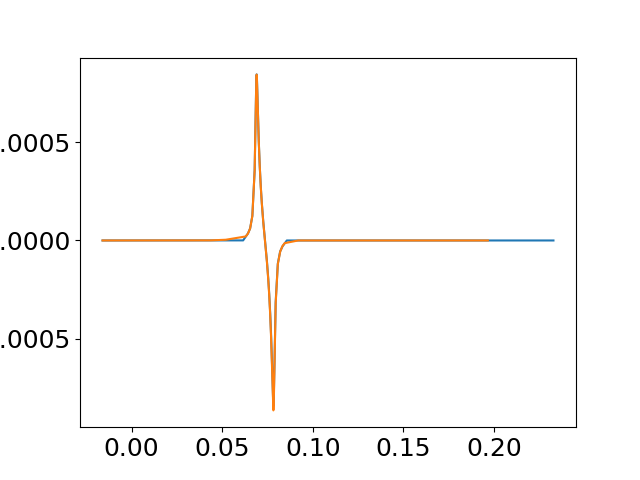

<IPython.core.display.Javascript object>


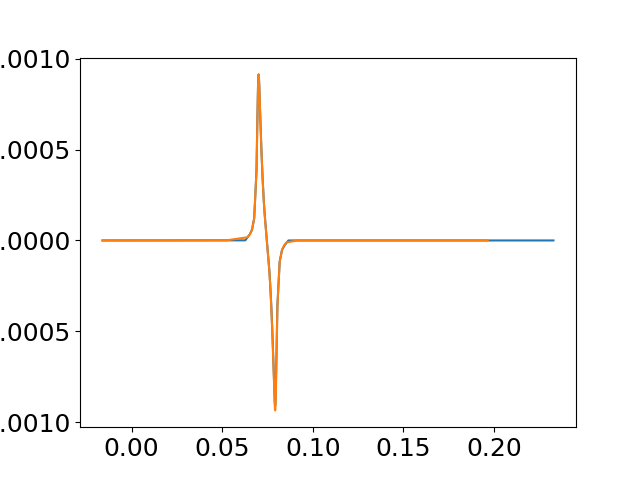

<IPython.core.display.Javascript object>


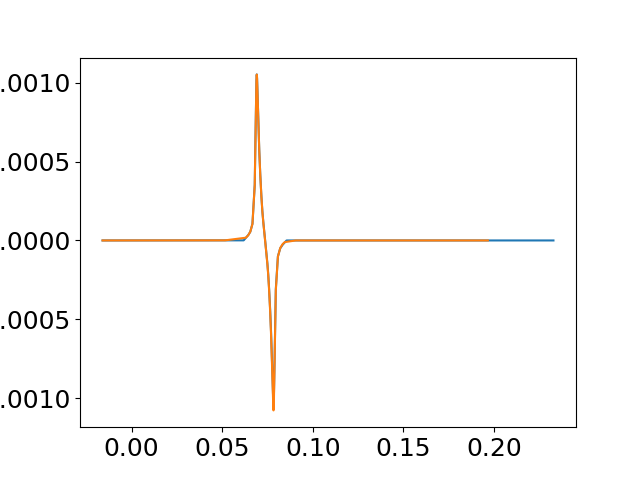

<IPython.core.display.Javascript object>


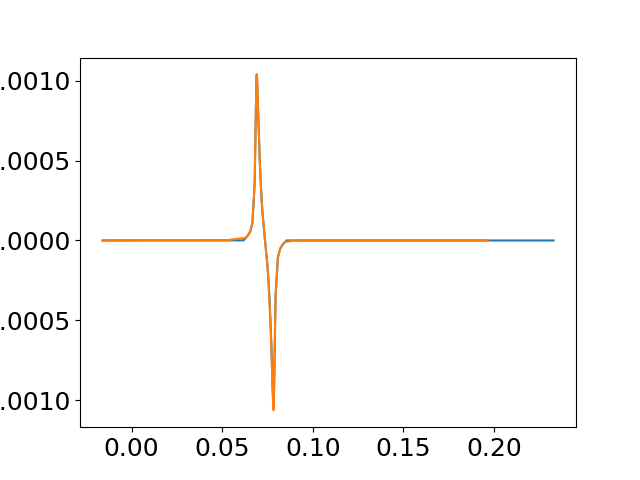

<IPython.core.display.Javascript object>


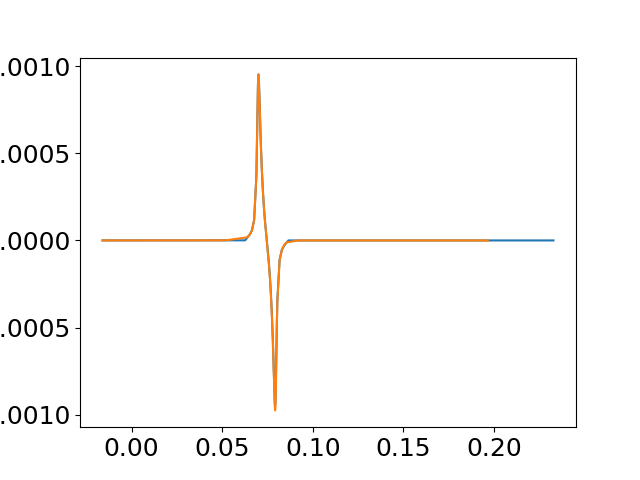

<IPython.core.display.Javascript object>


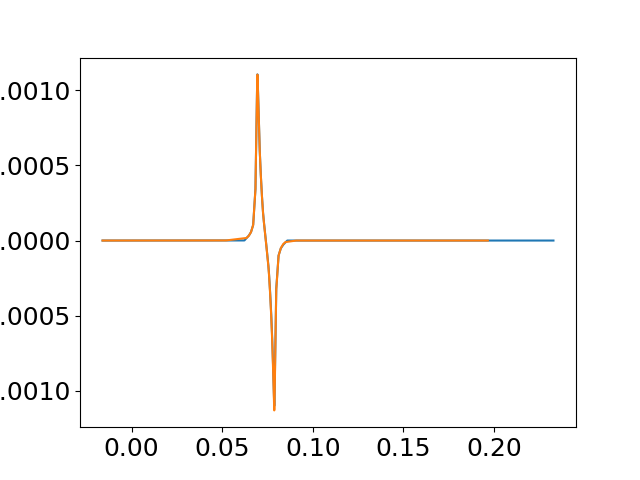

<IPython.core.display.Javascript object>


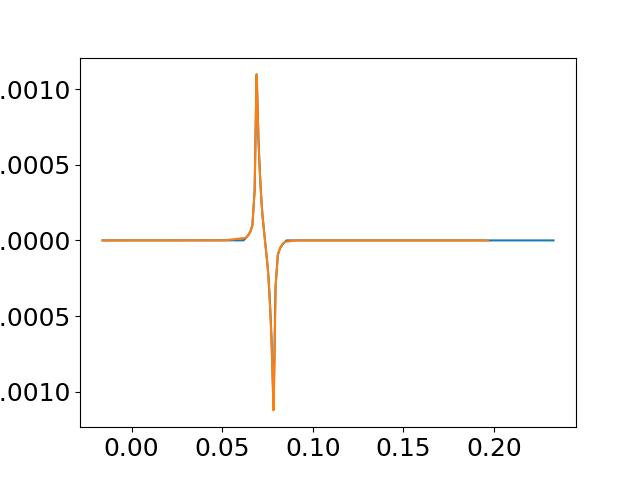

<IPython.core.display.Javascript object>


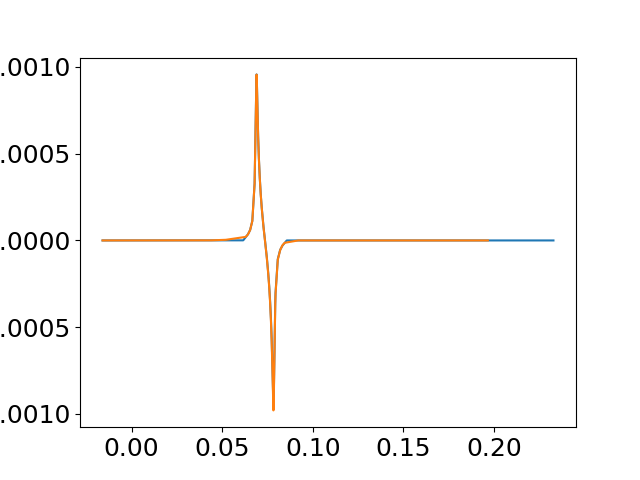

<IPython.core.display.Javascript object>


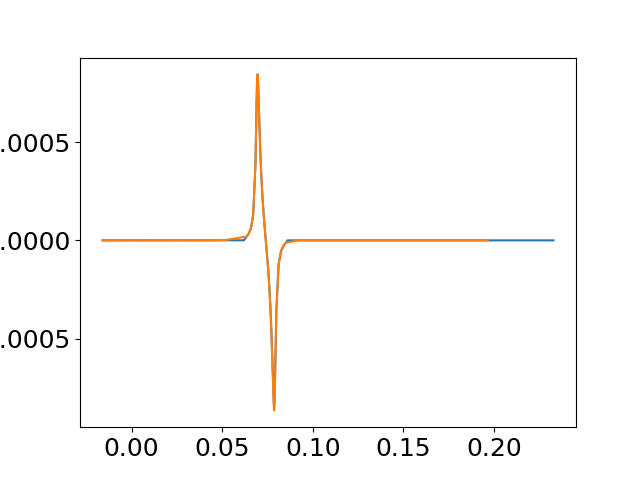

<IPython.core.display.Javascript object>


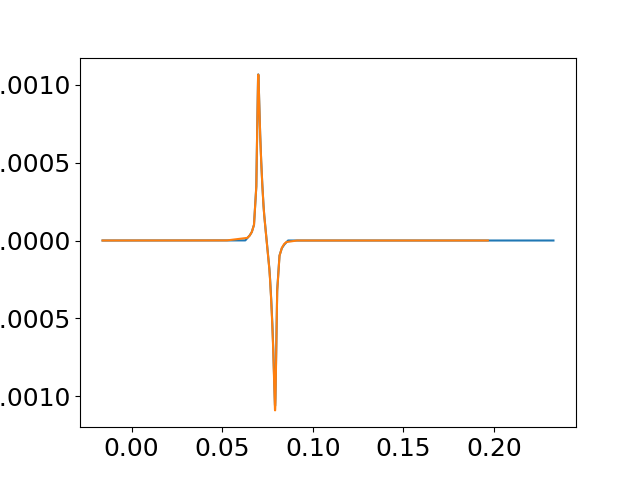

<IPython.core.display.Javascript object>


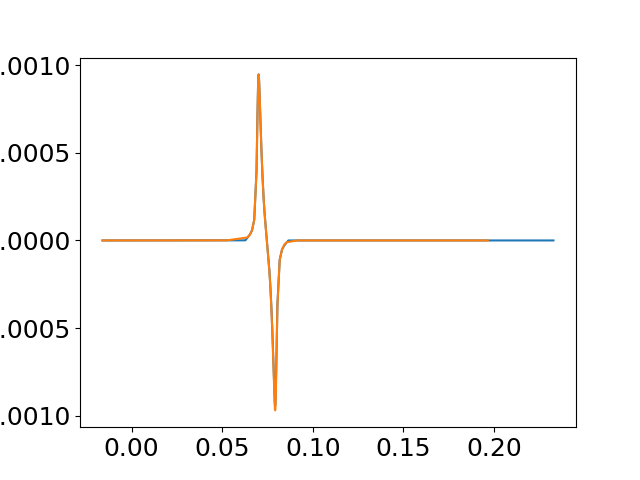

<IPython.core.display.Javascript object>


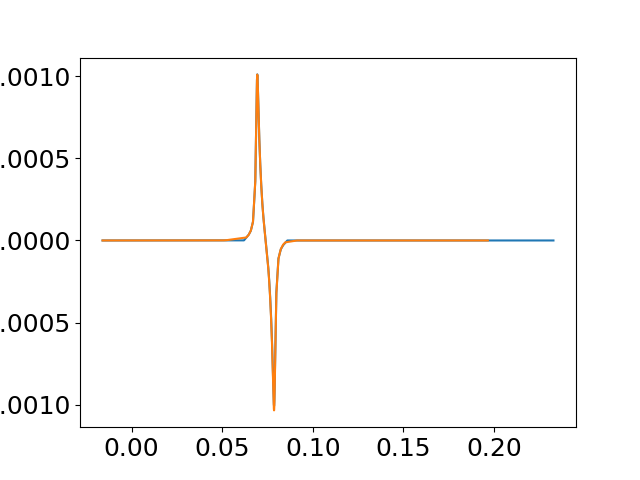

<IPython.core.display.Javascript object>


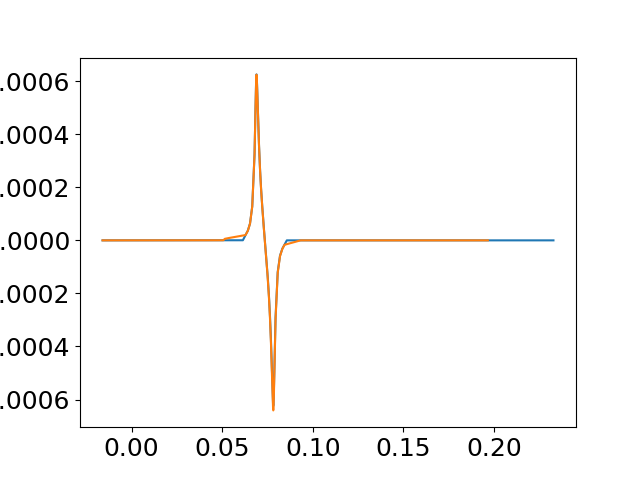

<IPython.core.display.Javascript object>


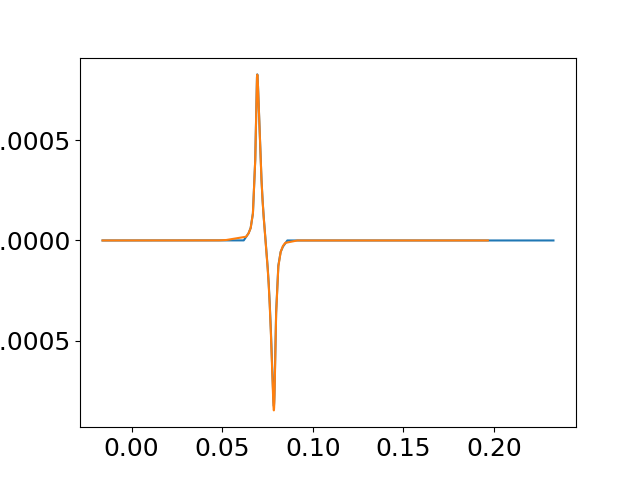

<IPython.core.display.Javascript object>


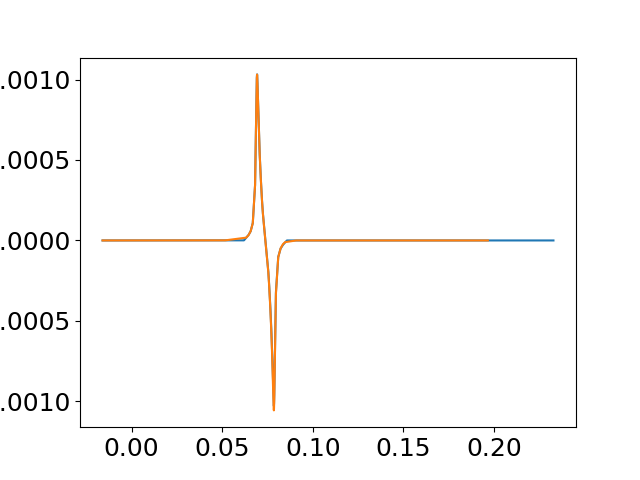

<IPython.core.display.Javascript object>


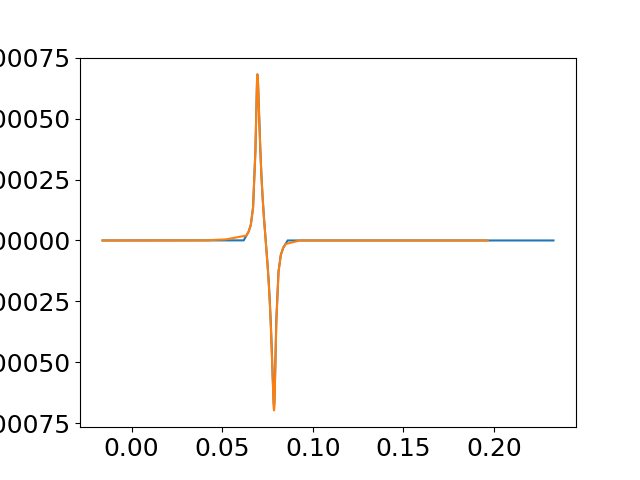

<IPython.core.display.Javascript object>


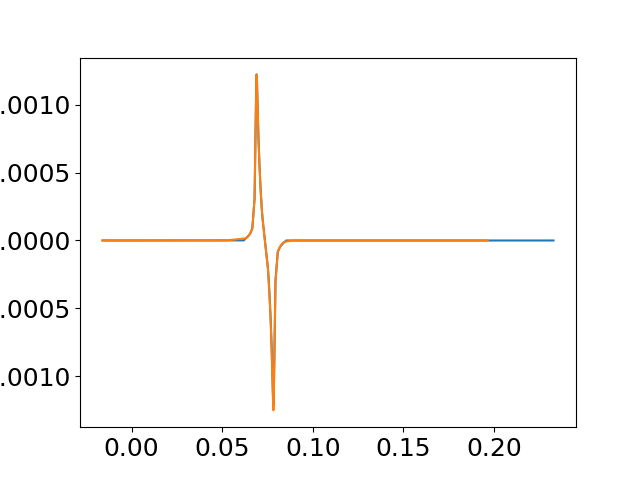

<IPython.core.display.Javascript object>


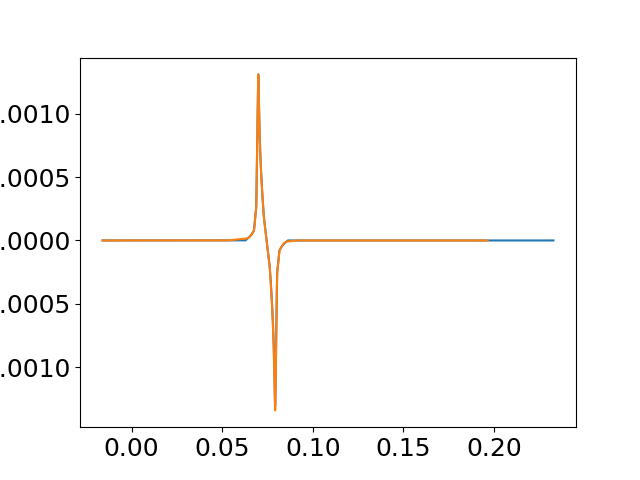

<IPython.core.display.Javascript object>


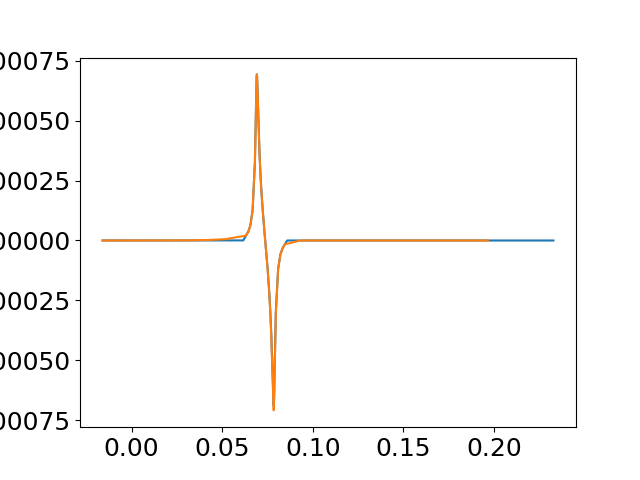

<IPython.core.display.Javascript object>


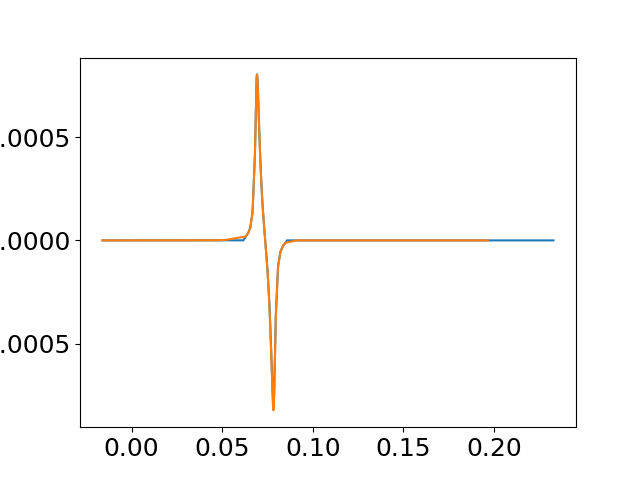

<IPython.core.display.Javascript object>


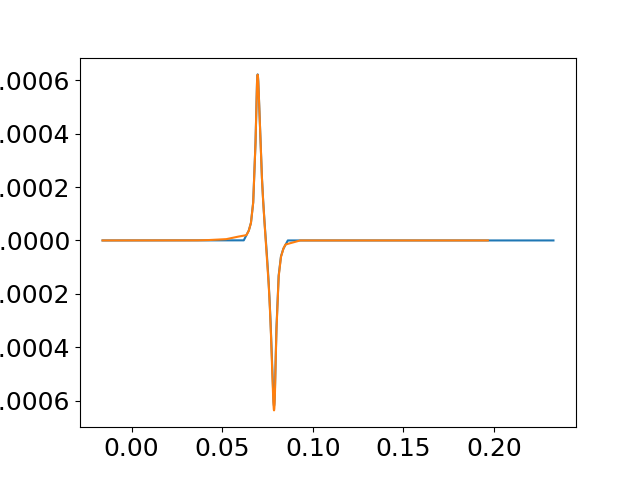

<IPython.core.display.Javascript object>


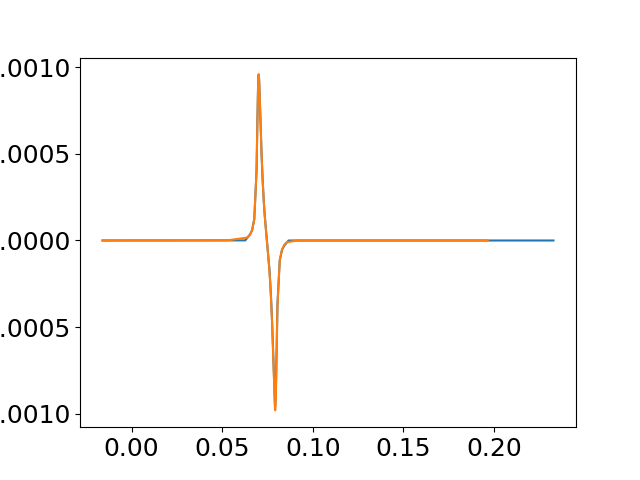

<IPython.core.display.Javascript object>


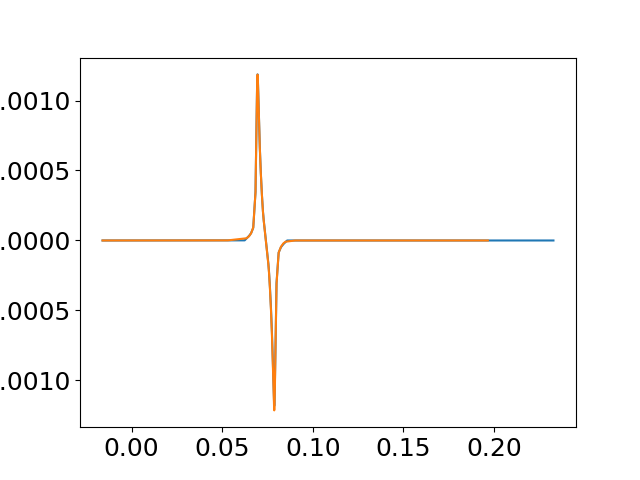

<IPython.core.display.Javascript object>


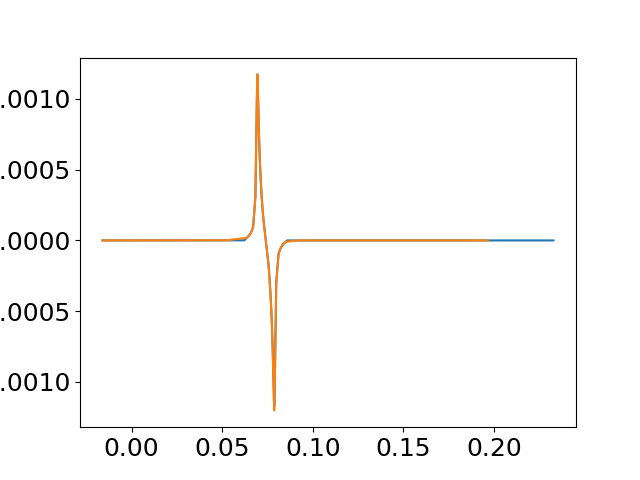

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


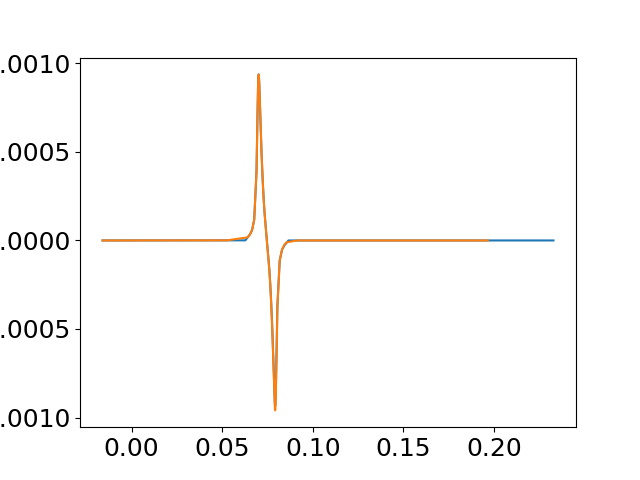

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


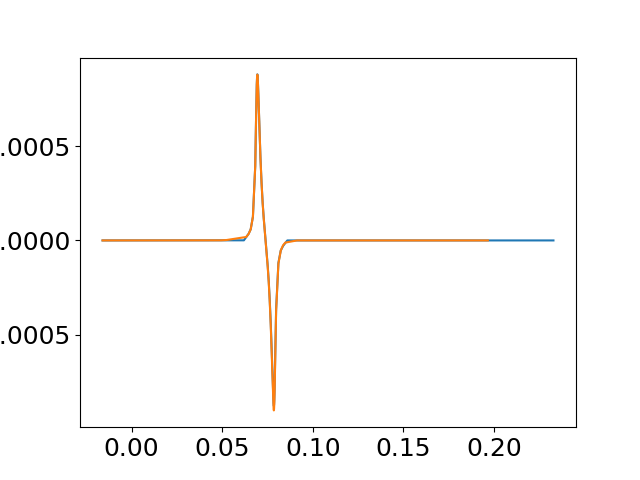

<IPython.core.display.Javascript object>


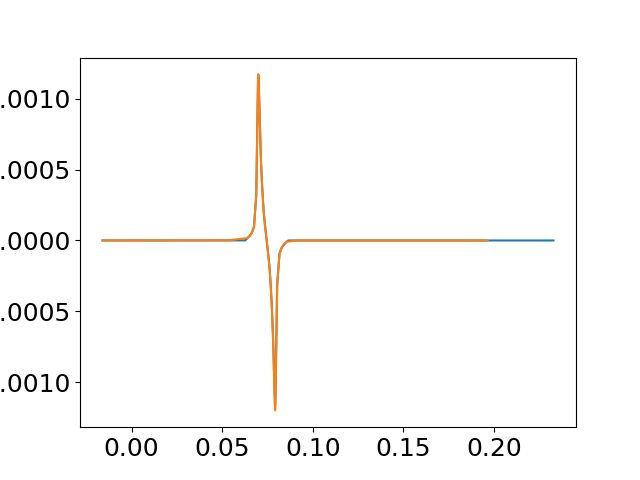

<IPython.core.display.Javascript object>


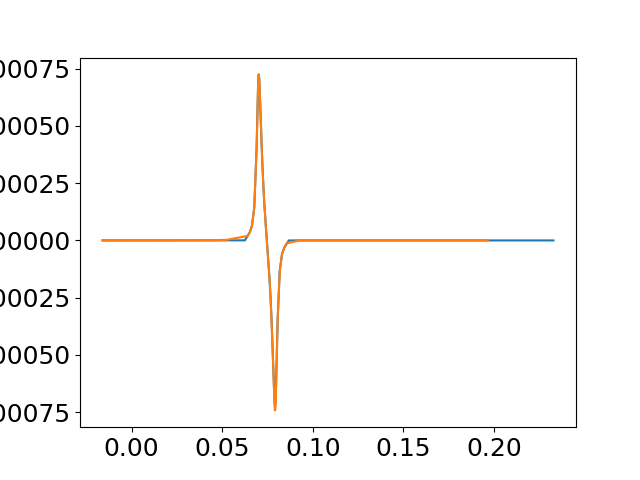

<IPython.core.display.Javascript object>


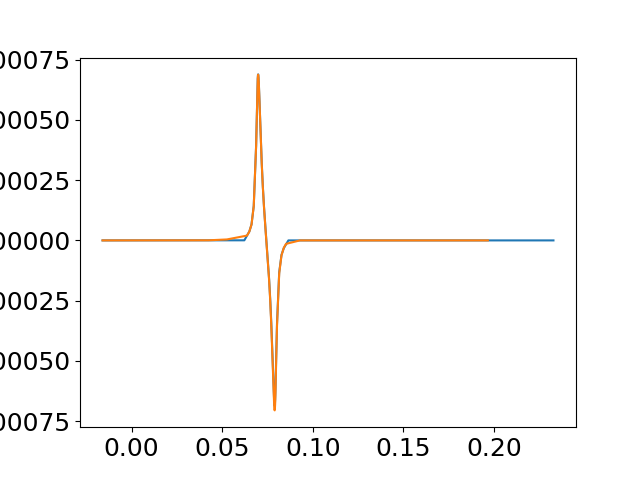

<IPython.core.display.Javascript object>


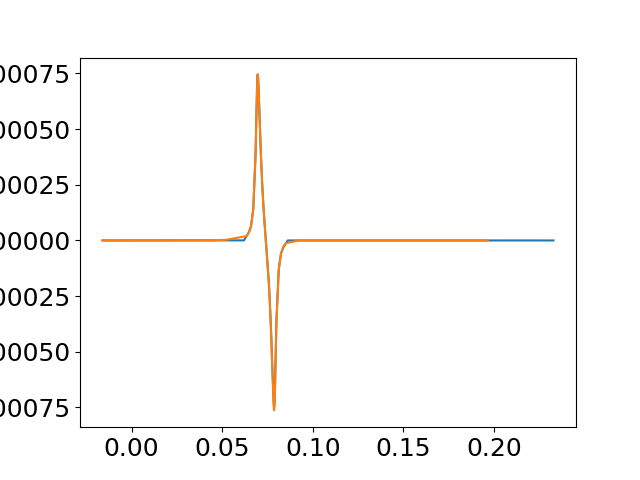

<IPython.core.display.Javascript object>


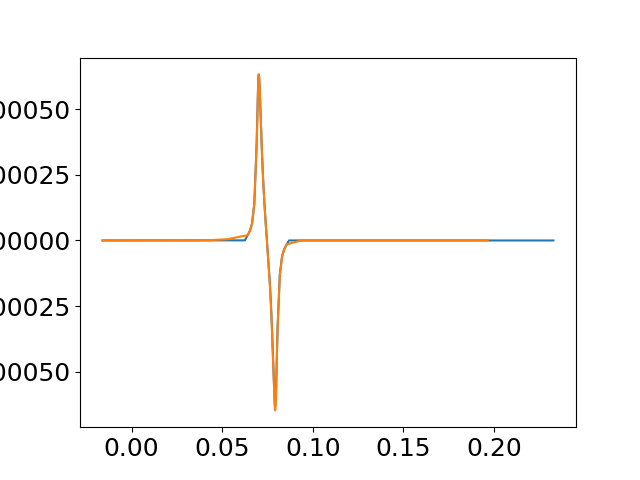

<IPython.core.display.Javascript object>


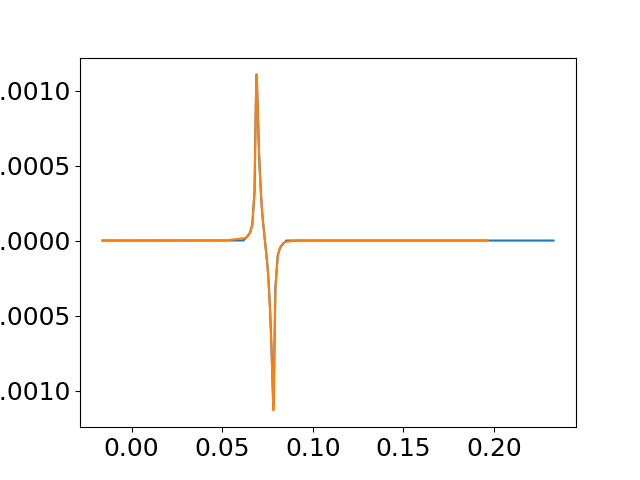

<IPython.core.display.Javascript object>


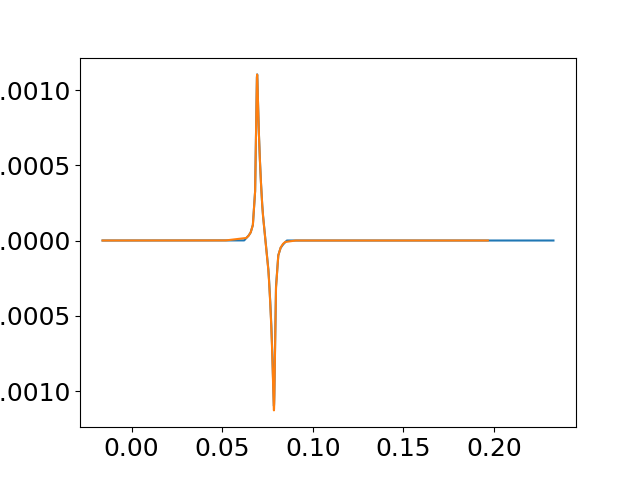

<IPython.core.display.Javascript object>


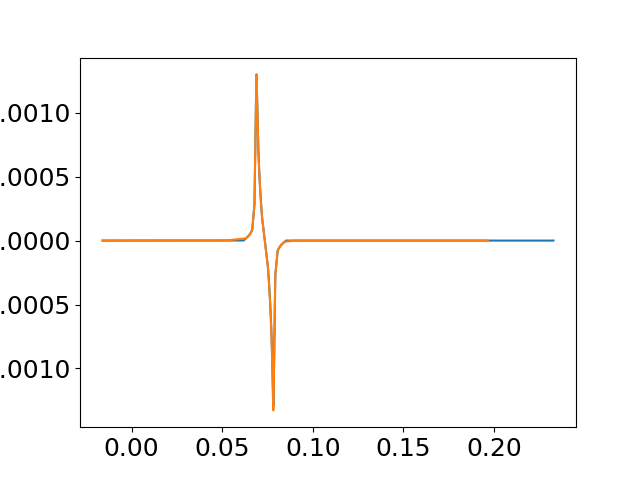

<IPython.core.display.Javascript object>


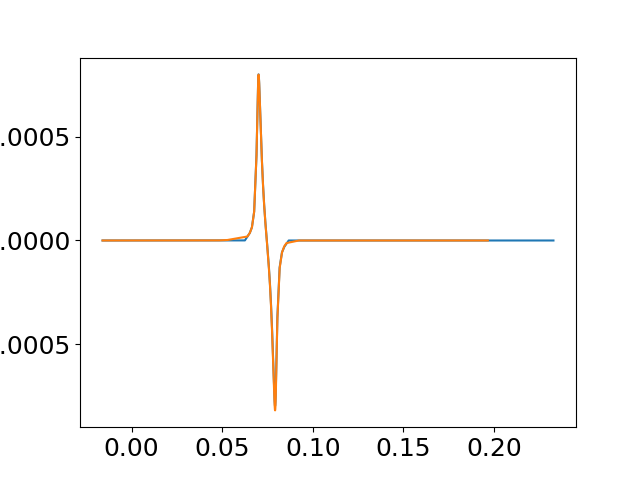

In [25]:

for i in range(39):

    
    plt.figure() 
    xvals, phiShapeEmpirical = FitPhiShape(i,0.07)
    xvals1, phiShapeEmpirical1 = FitPhiShapeClose(i,0.07)
    xvals2, phiShapeEmpirical2 = FitPhiShapeFar(i,0.07)
    plt.plot(xvals,phiShapeEmpirical)
    plt.plot(xvals1,phiShapeEmpirical1-phiShapeEmpirical2)

In [56]:
i

35